In [28]:
#pip install scikit-learn
import pandas as pd
import numpy as np
import re
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.utils import resample
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_selection import chi2
from sklearn.model_selection import train_test_split

### Lecture du fichier

In [29]:
train = pd.read_csv('jigsaw-toxic-comment-classification-challenge/train.csv')
test = pd.read_csv('jigsaw-toxic-comment-classification-challenge/test.csv')
print(train.shape, test.shape)
print(train.head(10))

(159571, 8) (153164, 2)
                 id                                       comment_text  toxic  \
0  0000997932d777bf  Explanation\nWhy the edits made under my usern...      0   
1  000103f0d9cfb60f  D'aww! He matches this background colour I'm s...      0   
2  000113f07ec002fd  Hey man, I'm really not trying to edit war. It...      0   
3  0001b41b1c6bb37e  "\nMore\nI can't make any real suggestions on ...      0   
4  0001d958c54c6e35  You, sir, are my hero. Any chance you remember...      0   
5  00025465d4725e87  "\n\nCongratulations from me as well, use the ...      0   
6  0002bcb3da6cb337       COCKSUCKER BEFORE YOU PISS AROUND ON MY WORK      1   
7  00031b1e95af7921  Your vandalism to the Matt Shirvington article...      0   
8  00037261f536c51d  Sorry if the word 'nonsense' was offensive to ...      0   
9  00040093b2687caa  alignment on this subject and which are contra...      0   

   severe_toxic  obscene  threat  insult  identity_hate  
0             0        0  

In [30]:
test_labels = pd.read_csv("jigsaw-toxic-comment-classification-challenge/test_labels.csv")

In [31]:
print(train.tail(50))

                      id                                       comment_text  \
159521  ff5e13378ca9d7a7  Improv\nWhat is the name of the part where the...   
159522  ff60fe590399538b  "\n\nThe bot does keep track, and will not upd...   
159523  ff65d85aebea05d0  I certainly noticed you because of the poor ed...   
159524  ff66383a2793fa14  "\n\nSorry I find that there's nothing ""honor...   
159525  ff6de7a60ebf8ab0    ( I really like this Icon where Can I get it ?)   
159526  ff6f6919e11cd5f4  request for checkuser \n\nHi\nGot your name fo...   
159527  ff7093e953e68d1e  Ok I am sorry, but I have created some article...   
159528  ff739ca9d4a89652  Wikipedia:Articles for deletion/Markus Kaarlon...   
159529  ff7464f7913986fc  "\nWhat do you answer to this: ""Timoshenko wa...   
159530  ff74bb5fff05ac53  ]]\nCategory:Musicians work group articles nee...   
159531  ff765c133935e1c5  Labeling Season 2B? \n\nHow should this be don...   
159532  ff76c8dcf1297d39  Paleoconservatism \n\nThe 

In [32]:
train['comment_text'] = train['comment_text'].fillna("").astype(str)
train['comment_text']
print(train.isna().sum())

id               0
comment_text     0
toxic            0
severe_toxic     0
obscene          0
threat           0
insult           0
identity_hate    0
dtype: int64


### EDA

is_toxic
0    143346
1     16225
Name: count, dtype: int64
is_toxic
0    0.898321
1    0.101679
Name: count, dtype: float64


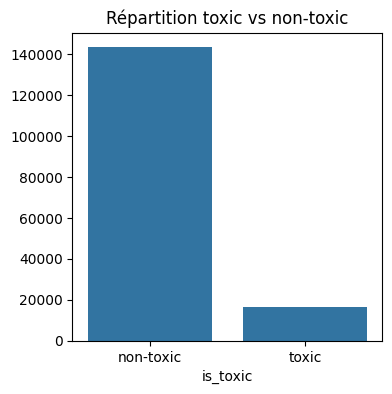

In [33]:
# Créer une colonne binaire : 1 si au moins une forme de toxicité est présente
train['is_toxic'] = (train[['toxic','severe_toxic','obscene','threat','insult','identity_hate']].sum(axis=1) > 0).astype(int)

counts = train['is_toxic'].value_counts()
print(counts)
print(counts / counts.sum())

plt.figure(figsize=(4,4))
sns.barplot(x=counts.index.map({0:'non-toxic',1:'toxic'}), y=counts.values)
plt.title("Répartition toxic vs non-toxic")
plt.show()


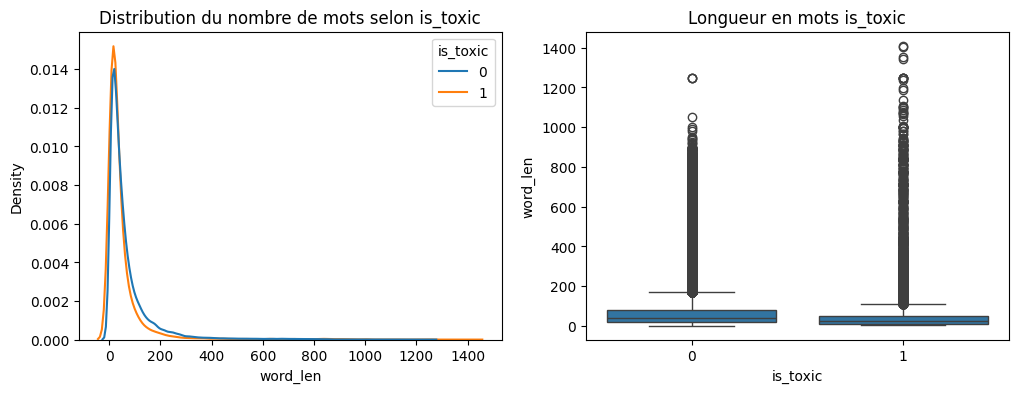

In [34]:
train['word_len'] = train['comment_text'].apply(lambda x: len(x.split()))
train['char_len'] = train['comment_text'].apply(len)

plt.figure(figsize=(12,4))
plt.subplot(1,2,1)
sns.kdeplot(data=train, x='word_len', hue='is_toxic', common_norm=False)
plt.title("Distribution du nombre de mots selon is_toxic")

plt.subplot(1,2,2)
sns.boxplot(x='is_toxic', y='word_len', data=train)
plt.title("Longueur en mots is_toxic")
plt.show()

In [35]:

tfv_expl = TfidfVectorizer(
    ngram_range=(1,2), max_features=50000, min_df=3, stop_words='english'
)
X_tfidf_expl = tfv_expl.fit_transform(train['comment_text'])
y_bin = train['is_toxic'].values

feature_names = np.array(tfv_expl.get_feature_names_out())
chi2scores, pvals = chi2(X_tfidf_expl, y_bin)

topn = 30
top_pos = np.argsort(chi2scores)[-topn:]
print("Top n-grams corrélés à toxic (is_toxic=1) :")
print(feature_names[top_pos])


Top n-grams corrélés à toxic (is_toxic=1) :
['dumb' 'sucks' 'fucker' 'bullshit' 'die' 'loser' 'fuck fuck' 'fuckin'
 'piece shit' 'moron' 'shut' 'nigger' 'penis' 'bastard' 'fag' 'hell'
 'cock' 'gay' 'dick' 'idiot' 'faggot' 'cunt' 'stupid' 'asshole' 'ass'
 'suck' 'bitch' 'shit' 'fucking' 'fuck']


In [36]:
def clean_text(text):
    text = re.sub(r"http\S+|www\S+", " ", text)  # enlever URLs
    text = re.sub(r"<.*?>", " ", text)           # enlever HTML
    text = re.sub(r"[^a-zA-Z']", " ", text)      # garder lettres et apostrophes
    text = re.sub(r"\s+", " ", text).strip()     # normaliser espaces
    return text.lower()

train['comment_text'] = train['comment_text'].apply(clean_text)

### Split train/validation

In [37]:
X = train['comment_text']
y = train['is_toxic'].values

X_train, X_val, y_train, y_val = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

print("Train class dist:", np.bincount(y_train))
print("Val class dist:", np.bincount(y_val))

Train class dist: [114676  12980]
Val class dist: [28670  3245]


#### Baseline sans oversampling

In [38]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_auc_score, classification_report

tfv_bin = TfidfVectorizer(
    ngram_range=(1,2),
    max_features=200000,
    min_df=3,
    stop_words='english'
)
X_train_tfidf = tfv_bin.fit_transform(X_train)
X_val_tfidf = tfv_bin.transform(X_val)

clf_bin = LogisticRegression(C=4, max_iter=2000, n_jobs=-1)
clf_bin.fit(X_train_tfidf, y_train)

y_val_proba = clf_bin.predict_proba(X_val_tfidf)[:,1]
y_val_pred = (y_val_proba >= 0.5).astype(int)

print("=== Baseline sans oversampling ===")
print("AUC:", roc_auc_score(y_val, y_val_proba))
print(classification_report(y_val, y_val_pred, digits=4))

=== Baseline sans oversampling ===
AUC: 0.9720934678287488
              precision    recall  f1-score   support

           0     0.9632    0.9919    0.9774     28670
           1     0.9030    0.6656    0.7664      3245

    accuracy                         0.9587     31915
   macro avg     0.9331    0.8288    0.8719     31915
weighted avg     0.9571    0.9587    0.9559     31915



In [39]:
test_labels['is_toxic'] = (test_labels[['toxic','severe_toxic','obscene','threat','insult','identity_hate']].sum(axis=1) > 0).astype(int)

mask = test_labels['is_toxic'] != -1
test_eval = test[mask].reset_index(drop=True)
test_labels_eval = test_labels[mask].reset_index(drop=True)

X_test_tfidf = tfv_bin.transform(test_eval['comment_text'])
y_test_true = test_labels_eval['is_toxic'].values

y_test_proba = clf_bin.predict_proba(X_test_tfidf)[:,1]
y_test_pred = (y_test_proba >= 0.5).astype(int)

# ==============================
# 4️⃣ Évaluation
# ==============================
print("=== Performance sur le fichier de test ===")
print("ROC-AUC:", roc_auc_score(y_test_true, y_test_proba))
print(classification_report(y_test_true, y_test_pred, digits=4))

=== Performance sur le fichier de test ===
ROC-AUC: 0.8872631077451105
              precision    recall  f1-score   support

           0     0.9882    0.8351    0.9052    146921
           1     0.1648    0.7657    0.2712      6243

    accuracy                         0.8322    153164
   macro avg     0.5765    0.8004    0.5882    153164
weighted avg     0.9547    0.8322    0.8794    153164



#### Baseline avec oversampling

In [40]:
from imblearn.over_sampling import SMOTE
from imblearn.pipeline import Pipeline as ImbPipeline

smote = SMOTE(
    sampling_strategy='auto',  # équilibre les classes
    k_neighbors=5,
    random_state=42
)

clf_smote = LogisticRegression(C=4, max_iter=2000, n_jobs=-1)

pipe_smote = ImbPipeline(steps=[
    ('tfidf', tfv_bin),
    ('smote', smote),
    ('clf', clf_smote)
])

pipe_smote.fit(X_train, y_train)

y_val_proba_smote = pipe_smote.predict_proba(X_val)[:,1]
y_val_pred_smote = (y_val_proba_smote >= 0.5).astype(int)

print("\n=== Modèle avec SMOTE ===")
print("AUC:", roc_auc_score(y_val, y_val_proba_smote))
print(classification_report(y_val, y_val_pred_smote, digits=4))


=== Modèle avec SMOTE ===
AUC: 0.9476858175196958
              precision    recall  f1-score   support

           0     0.9776    0.9381    0.9574     28670
           1     0.5970    0.8102    0.6874      3245

    accuracy                         0.9251     31915
   macro avg     0.7873    0.8741    0.8224     31915
weighted avg     0.9389    0.9251    0.9300     31915



### Transformer

In [41]:
# Oversampling simple de la classe toxic=1 par duplication
maj = train[train['is_toxic'] == 0]
minr = train[train['is_toxic'] == 1]

print("Avant oversampling:", len(maj), len(minr))

# multiplier les minoritaires par 3 (à ajuster selon le ratio)
minr_oversampled = pd.concat([minr] * 3, axis=0)

train_os = pd.concat([maj, minr_oversampled], axis=0)\
             .sample(frac=1, random_state=42)\
             .reset_index(drop=True)

print("Après oversampling binaire:")
print(train_os['is_toxic'].value_counts())

Avant oversampling: 143346 16225
Après oversampling binaire:
is_toxic
0    143346
1     48675
Name: count, dtype: int64


In [42]:
from datasets import Dataset
from transformers import AutoTokenizer, AutoModelForSequenceClassification, TrainingArguments, Trainer
import torch
from sklearn.metrics import roc_auc_score

# On repart de train_os (ou directement train si tu ne veux pas d'oversampling)
df = train_os.copy()

X_tr, X_val_tf, y_tr_tf, y_val_tf = train_test_split(
    df['comment_text'], df['is_toxic'],
    test_size=0.2, random_state=42, stratify=df['is_toxic']
)

train_df_hf = pd.DataFrame({'text': X_tr, 'label': y_tr_tf.values})
val_df_hf   = pd.DataFrame({'text': X_val_tf, 'label': y_val_tf.values})

train_dataset = Dataset.from_pandas(train_df_hf)
val_dataset   = Dataset.from_pandas(val_df_hf)

model_name = "roberta-base"
tokenizer = AutoTokenizer.from_pretrained(model_name)

max_length = 220  # suffisant pour la majorité des commentaires

def preprocess(examples):
    return tokenizer(
        examples['text'],
        truncation=True,
        padding='max_length',
        max_length=max_length
    )

train_dataset = train_dataset.map(preprocess, batched=True)
val_dataset   = val_dataset.map(preprocess, batched=True)

# On enlève les colonnes inutiles pour Trainer
train_dataset = train_dataset.remove_columns(['text', '__index_level_0__'])
val_dataset   = val_dataset.remove_columns(['text', '__index_level_0__'])

# Déclarer la colonne 'label' comme labels
train_dataset = train_dataset.rename_column('label', 'labels')
val_dataset   = val_dataset.rename_column('label', 'labels')

# Modèle binaire
model = AutoModelForSequenceClassification.from_pretrained(
    model_name,
    num_labels=2
)


Map: 100%|██████████| 38405/38405 [00:04<00:00, 9102.11 examples/s]
Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at roberta-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [43]:
from transformers import TrainingArguments
training_args = TrainingArguments(
    output_dir="C:/tmp/trainer_output",
    eval_strategy="epoch",
    save_strategy="epoch",
    # evaluate_during_training=True,  # ancien nom pour evaluation_strategy
    # save_total_limit=2, 
    per_device_train_batch_size=8,
    per_device_eval_batch_size=16,
    learning_rate=2e-5,
    num_train_epochs=3,
    weight_decay=0.01,
    load_best_model_at_end=True,
    metric_for_best_model="roc_auc",
    fp16=True,  # si GPU supporte
    logging_steps=200
)

In [44]:
from sklearn.metrics import roc_auc_score, f1_score, precision_recall_fscore_support

def compute_metrics(eval_pred):
    logits, labels = eval_pred
    probs = torch.softmax(torch.tensor(logits), dim=-1).numpy()
    preds = np.argmax(probs, axis=1)

    # Probabilité de la classe 1 (toxic)
    proba_toxic = probs[:,1]

    auc = roc_auc_score(labels, proba_toxic)
    precision, recall, f1, _ = precision_recall_fscore_support(labels, preds, average='binary')

    return {
        "roc_auc": auc,
        "precision": precision,
        "recall": recall,
        "f1": f1
    }


In [ ]:
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=val_dataset,
    tokenizer=tokenizer,
    compute_metrics=compute_metrics
)

trainer.train()

C:\Users\Stéphanie AGBODJOGBE\AppData\Local\Temp\ipykernel_12968\4030190838.py:1: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(
C:\Users\Stéphanie AGBODJOGBE\AppData\Roaming\Python\Python313\site-packages\torch\utils\data\dataloader.py:668: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  warnings.warn(warn_msg)


Epoch,Training Loss,Validation Loss


In [ ]:
eval_results = trainer.evaluate()
print(eval_results)

### Test

In [ ]:
# from tensorflow.keras.preprocessing.text import Tokenizer
# from tensorflow.keras.preprocessing.sequence import pad_sequences

# MAX_NUM_WORDS = 40000   # vocabulaire maximum
# MAX_LEN = 350          # longueur maximale des commentaires

# tokenizer = Tokenizer(num_words=MAX_NUM_WORDS, oov_token="<UNK>")
# tokenizer.fit_on_texts(train['comment_text'])

# X = tokenizer.texts_to_sequences(train['comment_text'])
# X = pad_sequences(X, maxlen=MAX_LEN)

# y = train['is_toxic'].values


In [ ]:
# from tensorflow.keras.models import Sequential
# from tensorflow.keras.layers import Embedding, LSTM, Dense, Dropout, Bidirectional

# model = Sequential([
#     Embedding(input_dim=MAX_NUM_WORDS, output_dim=100, input_length=MAX_LEN),
#     Bidirectional(LSTM(64, return_sequences=False)),
#     Dropout(0.3),
#     Dense(64, activation='relu'),
#     Dropout(0.2),
#     Dense(1, activation='sigmoid')   # sortie binaire : toxique ou non
# ])

# model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
# #model.summary()


In [ ]:
# from sklearn.model_selection import train_test_split
# from tensorflow.keras.callbacks import EarlyStopping

# X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.1, random_state=42)



# history = model.fit(
#     X_train, y_train,
#     validation_data=(X_val, y_val),
#     batch_size=128,
#     epochs=5
# )

Epoch 1/5
1122/1122 ━━━━━━━━━━━━━━━━━━━━ 1487s 1s/step - accuracy: 0.9440 - loss: 0.1685 - val_accuracy: 0.9399 - val_loss: 0.1938
Epoch 2/5
1122/1122 ━━━━━━━━━━━━━━━━━━━━ 1514s 1s/step - accuracy: 0.9580 - loss: 0.1260 - val_accuracy: 0.9625 - val_loss: 0.1034
Epoch 3/5
1122/1122 ━━━━━━━━━━━━━━━━━━━━ 1642s 1s/step - accuracy: 0.9696 - loss: 0.0835 - val_accuracy: 0.9655 - val_loss: 0.1050
Epoch 4/5
1122/1122 ━━━━━━━━━━━━━━━━━━━━ 14528s 13s/step - accuracy: 0.9759 - loss: 0.0660 - val_accuracy: 0.9610 - val_loss: 0.1273


In [ ]:
# loss, acc = model.evaluate(X_val, y_val)
# print(f"Accuracy = {acc:.3f}")

In [ ]:
# import numpy as np

# def predict_comment(comment):
#     seq = tokenizer.texts_to_sequences([clean_text(comment)])
#     seq = pad_sequences(seq, maxlen=MAX_LEN)
#     prob = model.predict(seq)[0][0]
#     label = "TOXIC" if prob > 0.5 else "NON TOXIC"
#     print(f"→ {label} ({prob:.2f})")

# predict_comment("I hate you, you're disgusting!")
# predict_comment("Thank you for your help, have a great day!")
